# The Daubechies D4 Wavelet Tranform

In [41]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt


def split_matrix(matrix): # divide the matrix into 4 quadrants
    leftSide, rightSide = np.split(matrix, 2, axis=1)
    appr, vD = np.split(leftSide, 2, axis=0)
    hD, dD = np.split(rightSide, 2, axis=0)
    
    return appr, hD, vD, dD

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def p_new(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix

In [42]:
def daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))

def daubechies4_wavelet_transform_2D(daubechies_coeffs,image):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))

    result_V = np.dot(daubechies_coeffs,result_H)
    
    return result_V

def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, result_V):
    daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
    result_H = np.dot(daubechies_coeffs_transpose, result_V)

    image = []
    for row in result_H:
        original_row = np.dot(daubechies_coeffs_transpose, row)
        image.append(original_row)

    return np.array(image)

root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [61]:
example = np.random.randint(0.0, 52.0, (6, 6))
example_daubechies_4 = daubechies_coeffs(np.zeros_like(example))
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")



Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.2241 -0.1294  0.      0.8365]
 [ 0.8365  0.     -0.1294 -0.2241  0.     -0.483 ]
 [ 0.2241  0.483   0.      0.8365 -0.1294  0.    ]
 [-0.1294  0.8365  0.     -0.483  -0.2241  0.    ]
 [ 0.      0.2241  0.483   0.      0.8365 -0.1294]
 [ 0.     -0.1294  0.8365  0.     -0.483  -0.2241]]


In [62]:
dwt = daubechies4_wavelet_transform_2D(example_daubechies_4,example)
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt)
print(f"\nOriginal Matrix:\n {example}")
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(dwt,4)}")
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(idwt,0)}")



Original Matrix:
 [[30 18 15 21 28 45]
 [15 49 40 30  6 35]
 [51 10  9 35 23 11]
 [ 1 51  5 48 47 46]
 [27  4 39 39 16  4]
 [27  9 19 42 13 47]]

Direct Daubechies Wavelet Transform:
 [[ 61.0884  48.9621  50.9895   2.2693 -21.9264  -2.7523]
 [ 48.5473  64.3775  57.7388 -30.975    9.6816 -14.7877]
 [ 25.7875  61.0784  58.9213  -5.7633 -18.9841  16.7393]
 [ -8.7333  -4.0332 -14.7353  -1.1202   7.3362  50.5798]
 [ -5.0422  10.3422 -26.7117  21.849    7.5806  16.7001]
 [ -7.4408 -15.0574  18.9127  -6.528   12.9517   8.1485]]

Direct Daubechies Wavelet Transform:
 [[30. 18. 15. 21. 28. 45.]
 [15. 49. 40. 30.  6. 35.]
 [51. 10.  9. 35. 23. 11.]
 [ 1. 51.  5. 48. 47. 46.]
 [27.  4. 39. 39. 16.  4.]
 [27.  9. 19. 42. 13. 47.]]


## IMAGES EXAMPLES

In [45]:
photo = 'imagen.jpg'

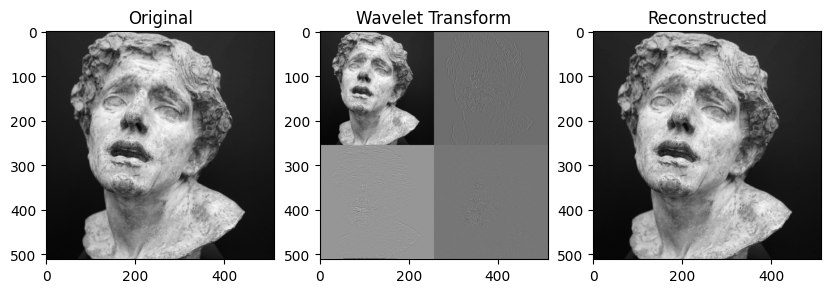

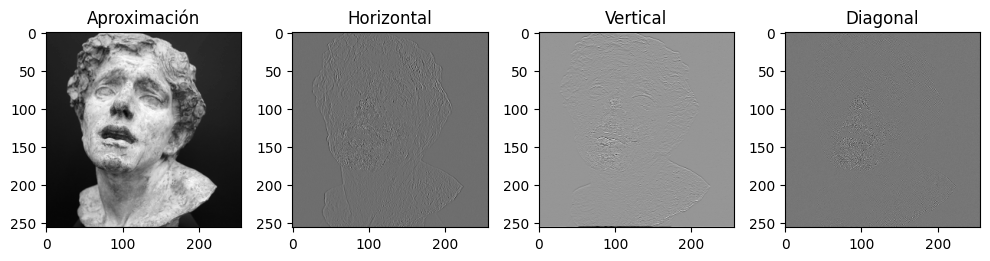

In [46]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img)

aP,cH,cV,cD = split_matrix(result_img)

sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()

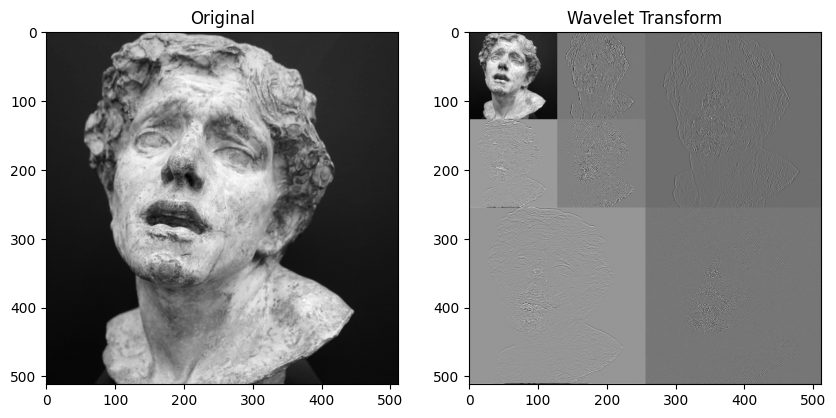

In [47]:
result_img2 = daubechies4_wavelet_transform_2D(daubechies_coeffs(aP),aP)

aP1,cH1,cV1,cD1 = split_matrix(result_img2)
sup_img = np.concatenate((p_new(aP1),p_new(cH1)), axis=1)
inf_img = np.concatenate((p_new(cV1),p_new(cD1)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)


sup_img = np.concatenate((result_img2,p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

## Others examples

In [54]:
photo = 'mario.png'

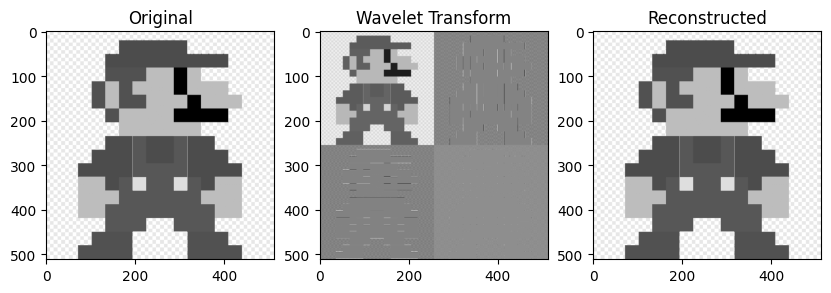

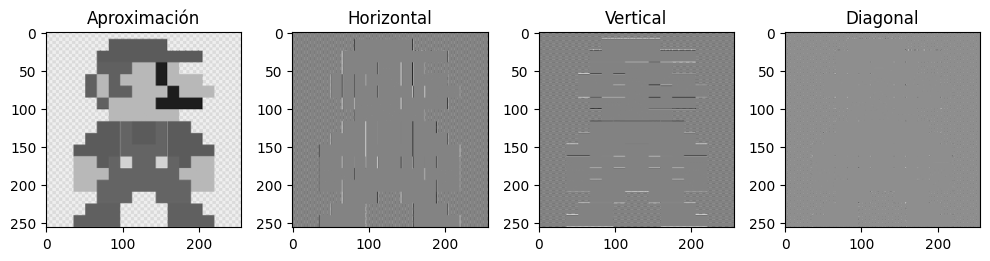

In [55]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()

In [57]:
photo = 'imagen2.jpeg'

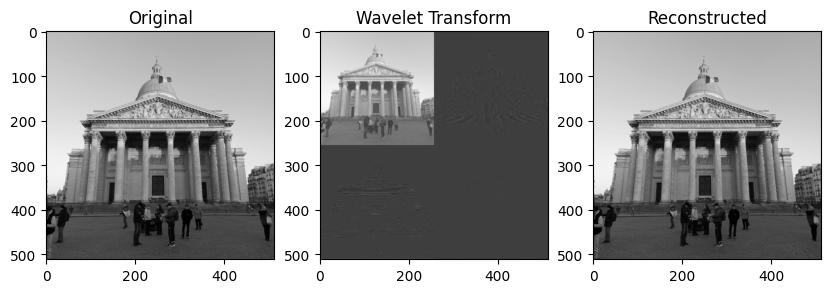

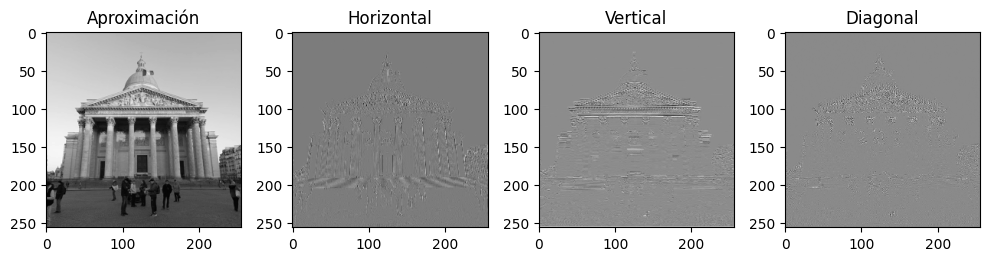

In [58]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

# sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()